In [1]:
import os
import gzip
import shutil
import requests
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor, LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

In [2]:
# DATA COLLECTION FUNCTION

def download_data(config):
    """
    Downloads and extracts compressed CSV files from GitHub repository.
    Files are compressed as .gz and need to be extracted.

    Args:
        config (dict): Configuration dictionary with 'data_path' and 'base_url'
    """
    # Create the target directory if it doesn't exist
    os.makedirs(config['data_path'], exist_ok=True)

    # Map expected filenames to actual GitHub filenames (compressed)
    file_mapping = {
        "prix-carburants-2022-part1.csv": "Prix2022S1.csv.gz",
        "prix-carburants-2022-part2.csv": "Prix2022S2.csv.gz",
        "prix-carburants-2023.csv": "Prix2023.csv.gz",
        "prix-carburants-2024.csv": "Prix2024.csv.gz",
        "stations-2024.csv": "Stations2024.csv.gz",
        "services-2024.csv": "Services2024.csv.gz"
    }

    # Source URL for the datasets
    base_url = "https://raw.githubusercontent.com/rvm-courses/GasPrices/master/"

    # Iterate through the mapping to download each file
    for output_name, github_name in file_mapping.items():
        output_path = os.path.join(config['data_path'], output_name)

        # Check if file is already present to avoid redundant downloads
        if os.path.exists(output_path):
            print(f"✓ {output_name} already exists")
            continue

        print(f"Downloading {github_name}...")

        try:
            # Execute HTTP GET request to fetch the compressed file
            url = base_url + github_name
            response = requests.get(url, timeout=60)

            # If download is successful, save and decompress
            if response.status_code == 200:
              # Write the raw bytes to a temporary .gz file
                gz_path = os.path.join(config['data_path'], github_name)
                with open(gz_path, 'wb') as f:
                    f.write(response.content)

                # Use gzip module to decompress into a standard CSV
                print(f"  Extracting {github_name}...")
                with gzip.open(gz_path, 'rb') as f_in:
                    with open(output_path, 'wb') as f_out:
                        shutil.copyfileobj(f_in, f_out)

                # Remove compressed file
                os.remove(gz_path)

                print(f"Successfully downloaded and extracted {output_name}")
            else:
                print(f"Failed to download {github_name}. Status: {response.status_code}")

        except Exception as e:
            print(f"Error downloading {github_name}: {e}")


# CONFIGURATION SETUP

def create_default_config():
    """Creates a default configuration if config.yaml doesn't exist"""
    # Define project parameters including data source and filtering logic
    default_config = {
        'data_path': './gas_data',
        'base_url': 'https://raw.githubusercontent.com/rvm-courses/GasPrices/master/',
        'first_year': 2022,
        'last_year': 2024,
        'exclude_gas_types': ['E85', 'GPLc'],  # Low-frequency types to exclude
        'geojson_url': 'https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/departements.geojson'
    }

    with open('config.yaml', 'w') as f:
        yaml.dump(default_config, f, default_flow_style=False)

    return default_config

# Load or create configuration
if os.path.exists('config.yaml'):
    with open('config.yaml', 'r') as f:
        config = yaml.safe_load(f)
    print("Configuration loaded from config.yaml")
else:
    config = create_default_config()
    print("Default configuration created (config.yaml)")


# SPARK SESSION INITIALIZATION

spark = SparkSession.builder \
    .appName("FrenchGasPricesAnalysis") \
    .config("spark.sql.session.timeZone", "UTC") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

print(f"Spark session started (version {spark.version})")


# DATA COLLECTION

download_data(config)

# Verify files exist before proceeding
required_files = [
    "prix-carburants-2022-part1.csv",
    "prix-carburants-2022-part2.csv",
    "prix-carburants-2023.csv",
    "prix-carburants-2024.csv"
]

missing_files = [f for f in required_files if not os.path.exists(os.path.join(config['data_path'], f))]
if missing_files:
    print(f"Warning: Missing files: {missing_files}")
    print("Please download manually from: https://github.com/rvm-courses/GasPrices")
    raise FileNotFoundError(f"Required files missing: {missing_files}")


Configuration loaded from config.yaml
Spark session started (version 4.0.1)
  Extracting Prix2022S1.csv.gz...
Successfully downloaded and extracted prix-carburants-2022-part1.csv
  Extracting Prix2022S2.csv.gz...
Successfully downloaded and extracted prix-carburants-2022-part2.csv
  Extracting Prix2023.csv.gz...
Successfully downloaded and extracted prix-carburants-2023.csv
  Extracting Prix2024.csv.gz...
Successfully downloaded and extracted prix-carburants-2024.csv
  Extracting Stations2024.csv.gz...
Successfully downloaded and extracted stations-2024.csv
  Extracting Services2024.csv.gz...
Successfully downloaded and extracted services-2024.csv


In [3]:
# DATA PREPARATION

# Load files individually (they don't have headers)
print("Loading gas price data...")

# Define column names based on documentation
price_columns = ["id_station", "cp", "pop", "latitude", "longitude",
                 "date", "id_carburant", "nom_carburant", "prix"]

# Loop through years defined in config to load data into Spark DataFrames
dfs = []
for year in range(config['first_year'], config['last_year'] + 1):
    if year == 2022:
        # Handle the split file structure of 2022
        for part in [1, 2]:
            path = f"{config['data_path']}/prix-carburants-2022-part{part}.csv"
            if os.path.exists(path):
                df_temp = spark.read \
                    .option("header", "false") \
                    .option("sep", ";") \
                    .option("inferSchema", "true") \
                    .csv(path) \
                    .toDF(*price_columns)
                dfs.append(df_temp)
                count = df_temp.count()
                print(f"✓ Loaded 2022-part{part}: {count:,} records")
    else:
        path = f"{config['data_path']}/prix-carburants-{year}.csv"
        if os.path.exists(path):
            df_temp = spark.read \
                .option("header", "false") \
                .option("sep", ";") \
                .option("inferSchema", "true") \
                .csv(path) \
                .toDF(*price_columns)
            dfs.append(df_temp)
            count = df_temp.count()
            print(f"✓ Loaded {year}: {count:,} records")

if not dfs:
    raise FileNotFoundError("No price data files could be loaded")

# Merge all yearly DataFrames into a single master DataFrame
raw_df = dfs[0]
for df in dfs[1:]:
    raw_df = raw_df.union(df)

total_records = raw_df.count()
print(f"\n✓ Total records loaded: {total_records:,}")

# Show sample of raw data
print("\nSample of raw date values:")
raw_df.select("date").limit(5).show()

# Date splitting and coordinate normalization
print("\nProcessing dates and coordinates...")
# 1. Cast date to string to apply Regex and extract YYYY-MM-DD
# 2. Divide Latitude/Longitude/Price by scale factors to get correct units
df = raw_df.withColumn("date_str", F.col("date").cast("string")) \
    .withColumn("date_only", F.regexp_extract(F.col("date_str"), r'^(\d{4}-\d{2}-\d{2})', 1)) \
    .withColumn("date", F.to_date(F.col("date_only"), "yyyy-MM-dd")) \
    .withColumn("year", F.year("date")) \
    .withColumn("month", F.month("date")) \
    .withColumn("week", F.weekofyear("date")) \
    .withColumn("latitude", F.col("latitude") / 100000) \
    .withColumn("longitude", F.col("longitude") / 100000) \
    .withColumn("prix", F.col("prix") / 100)

# Drop temporary columns
df = df.drop("date_str", "date_only")

# Basic statistics on gas types
print("\nGas type distribution:")
gas_stats = df.groupBy("nom_carburant") \
    .agg(
        F.count("*").alias("count"),
        F.avg("prix").alias("avg_price"),
        F.min("prix").alias("min_price"),
        F.max("prix").alias("max_price")
    ) \
    .orderBy(F.desc("count"))

gas_stats.show()

# Filter out infrequent gas types
print(f"\n⚠ Excluding gas types: {config['exclude_gas_types']}")
df = df.filter(~F.col("nom_carburant").isin(config['exclude_gas_types']))

print(f"Records after filtering: {df.count():,}")

# Show date range
print("\nDate range in dataset:")
df.select(F.min("date").alias("min_date"), F.max("date").alias("max_date")).show()

# Register as SQL table for Spark SQL queries
df.createOrReplaceTempView("gas_prices")
print("Table 'gas_prices' created for Spark SQL")


# DATA PREPARATION - STEP 2

# Calculate Price Index
print("Calculating Price Index...")
day_avg = df.groupBy("date", "nom_carburant") \
    .agg(F.avg("prix").alias("avg_day_france"))

df = df.join(day_avg, ["date", "nom_carburant"], "left")
df = df.withColumn(
    "Price_Index",
    100 * (((F.col("prix") - F.col("avg_day_france")) / F.col("avg_day_france")) + 1)
)

# Calculate Week Index (weeks since first week in dataset)
print("Calculating Week Index...")
# Get the minimum date safely
min_date_result = df.agg(F.min("date")).collect()
if min_date_result and min_date_result[0][0]:
    min_date = min_date_result[0][0]
    print(f"First date in dataset: {min_date}")

    # Number of days since start divided by 7
    df = df.withColumn(
        "Week_Index",
        F.floor(F.datediff(F.col("date"), F.lit(min_date)) / 7) + 1
    )

    max_week = df.agg(F.max('Week_Index')).collect()[0][0]
    print(f"✓ Week Index range: 1 to {max_week}")
else:
    print(" Could not determine minimum date, using fallback...")
    # manually set min_date if needed
    min_date = datetime.strptime(f"{config['first_year']}-01-01", "%Y-%m-%d")
    df = df.withColumn(
        "Week_Index",
        F.floor(F.datediff(F.col("date"), F.lit(min_date)) / 7) + 1
    )
    max_week = df.agg(F.max('Week_Index')).collect()[0][0]
    print(f"✓ Week Index range: 1 to {max_week} (using fallback date)")

# Keep data in memory to speed up subsequent aggregations and visualizations
df.cache()
print("✓ Data cached for performance")

# Sample data inspection
print("\nSample of processed data:")
df.select("date", "nom_carburant", "prix", "Price_Index", "Week_Index").show(10)

Loading gas price data...
✓ Loaded 2022-part1: 2,630,689 records
✓ Loaded 2022-part2: 2,304,432 records
✓ Loaded 2023: 4,687,530 records
✓ Loaded 2024: 4,592,186 records

✓ Total records loaded: 14,214,837

Sample of raw date values:
+-------------------+
|               date|
+-------------------+
|2022-01-03 08:44:18|
|2022-01-05 10:08:11|
|2022-01-10 10:09:08|
|2022-01-17 12:34:42|
|2022-01-17 12:34:44|
+-------------------+


Processing dates and coordinates...

Gas type distribution:
+-------------+-------+--------------------+--------------------+-------------------+
|nom_carburant|  count|           avg_price|           min_price|          max_price|
+-------------+-------+--------------------+--------------------+-------------------+
|       Gazole|4245380|0.018076891830643954|              1.0E-5|0.09999000000000001|
|          E10|3559498|0.018212468297490795|              1.0E-5|0.09999000000000001|
|         SP98|3425844| 0.01914608725323685|              1.0E-5|0.099990000

Generating weekly price evolution plot...
Saved: weekly_price_evolution.png


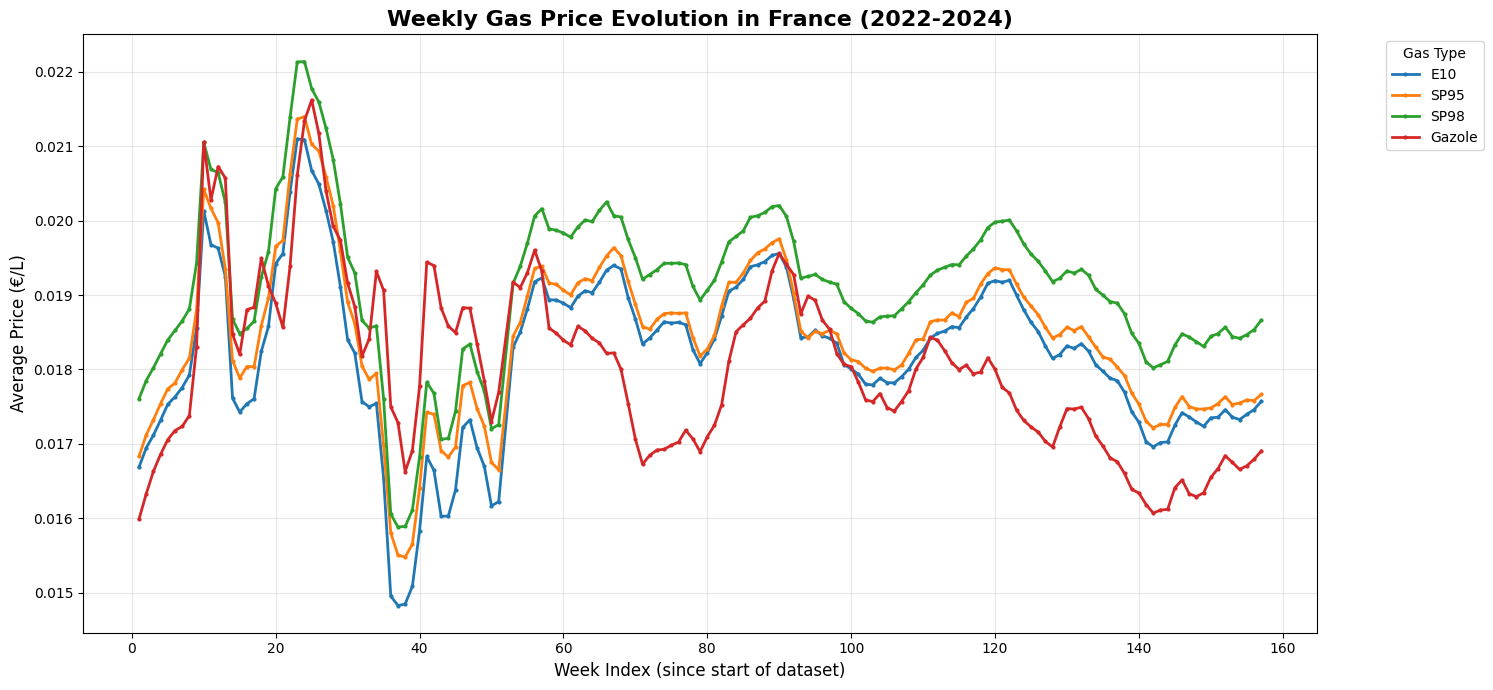

In [4]:
# DATA VISUALIZATION

# Weekly evolution of average gas prices
print("Generating weekly price evolution plot...")
weekly_evolution = df.groupBy("Week_Index", "nom_carburant") \
    .agg(F.avg("prix").alias("avg_price")) \
    .orderBy("Week_Index") \
    .toPandas()

# Plotting using Matplotlib
plt.figure(figsize=(15, 7))
for gas_type in weekly_evolution['nom_carburant'].unique():
    data = weekly_evolution[weekly_evolution['nom_carburant'] == gas_type]
    plt.plot(data['Week_Index'], data['avg_price'], marker='o',
             markersize=2, label=gas_type, linewidth=2)

plt.title("Weekly Gas Price Evolution in France (2022-2024)",
          fontsize=16, fontweight='bold')
plt.xlabel("Week Index (since start of dataset)", fontsize=12)
plt.ylabel("Average Price (€/L)", fontsize=12)
plt.legend(title="Gas Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("weekly_price_evolution.png", dpi=300, bbox_inches='tight')
print("Saved: weekly_price_evolution.png")
plt.show()

In [18]:
# GEOGRAPHIC VISUALIZATION
try:
    import folium
    from folium.plugins import MarkerCluster

    print("Creating department-level maps with station clusters...")

    # Prepare Department Data for the Choropleth
    # Extract department code (first 2 digits of postal code)
    df = df.withColumn("dept_code", F.substring(F.col("cp").cast("string"), 1, 2))

    # Pre-calculate averages by department to keep the data sent to Folium light
    dept_prices_spark = df.groupBy("dept_code", "nom_carburant") \
        .agg(F.avg("Price_Index").alias("avg_price_index"))

    dept_prices_pd = dept_prices_spark.toPandas()

    # Create a map for each gas type
    for gas_type in dept_prices_pd['nom_carburant'].unique():
        print(f" Processing map for: {gas_type}...")
        gas_dept_data = dept_prices_pd[dept_prices_pd['nom_carburant'] == gas_type]

        # Initialize the map centered on France
        m = folium.Map(location=[46.2276, 2.2137], zoom_start=6)

        # CHOROPLETH (Department Level Price Index)
        try:
            folium.Choropleth(
                geo_data=config['geojson_url'],
                name=f"{gas_type} Price Index",
                data=gas_dept_data,
                columns=["dept_code", "avg_price_index"],
                key_on="feature.properties.code",
                fill_color="YlOrRd",
                fill_opacity=0.6,
                line_opacity=0.2,
                legend_name=f"Avg Price Index - {gas_type} (%)",
                nan_fill_color="lightgray"
            ).add_to(m)
        except Exception as e:
            print(f"  Warning: Choropleth failed for {gas_type}, continuing with markers: {e}")

        # STATION CLUSTERS (Individual Station Details)
        # I'm tacking a 5% random sample of stations for visual performance
        station_sample = df.filter(F.col("nom_carburant") == gas_type) \
            .select("latitude", "longitude", "prix", "nom_carburant") \
            .sample(withReplacement=False, fraction=0.05, seed=42) \
            .limit(1000) \
            .toPandas()

        # Add a MarkerCluster layer for interactivity
        marker_cluster = MarkerCluster(name="Station Details (Sampled)").add_to(m)

        for _, row in station_sample.iterrows():
            folium.CircleMarker(
                location=[row['latitude'], row['longitude']],
                radius=4,
                popup=f"Fuel: {row['nom_carburant']}<br>Price: {row['prix']:.3f}€",
                color='blue',
                fill=True,
                fill_color='blue',
                fill_opacity=0.7
            ).add_to(marker_cluster)

        # Add layer control to toggle between Choropleth and Stations
        folium.LayerControl().add_to(m)

        # Save the map
        filename = f"gas_price_{gas_type.replace(' ', '_').replace('/', '_')}.html"
        m.save(filename)
        print(f" Successfully saved: {filename}")

except ImportError:
    print(" Folium not installed. Skipping geographic visualization.")
except Exception as e:
    print(f" Error in Geographic Visualization: {e}")

Creating department-level maps with station clusters...
 Processing map for: SP95...
  ✓ Successfully saved: gas_price_SP95.html
 Processing map for: Gazole...
  ✓ Successfully saved: gas_price_Gazole.html
 Processing map for: E10...
  ✓ Successfully saved: gas_price_E10.html
 Processing map for: SP98...
  ✓ Successfully saved: gas_price_SP98.html


Loading services data...
Exploration of available services...
First 20 unique services found:
  - Location de véhicule,Lavage automatique,Vente de gaz domestique (Butane, Propane),DAB (Distributeur automatique de billets)
  - Toilettes publiques,Douches,Boutique alimentaire,Boutique non alimentaire,Restauration à emporter,Restauration sur place,Bar,Vente de fioul domestique,Vente de pétrole lampant,Station de gonflage,Carburant additivé,Piste poids lourds,Vente de gaz domestique (Butane, Propane),DAB (Distributeur automatique de billets)
  - Toilettes publiques,Laverie,Boutique alimentaire,Boutique non alimentaire,Restauration à emporter,Bar,Vente de gaz domestique (Butane, Propane),DAB (Distributeur automatique de billets)
  - Vente de pétrole lampant,Station de gonflage,Piste poids lourds,Vente de gaz domestique (Butane, Propane),DAB (Distributeur automatique de billets)
  - Station de gonflage,Aire de camping-cars,Vente de gaz domestique (Butane, Propane)
  - Boutique alimentaire,Re

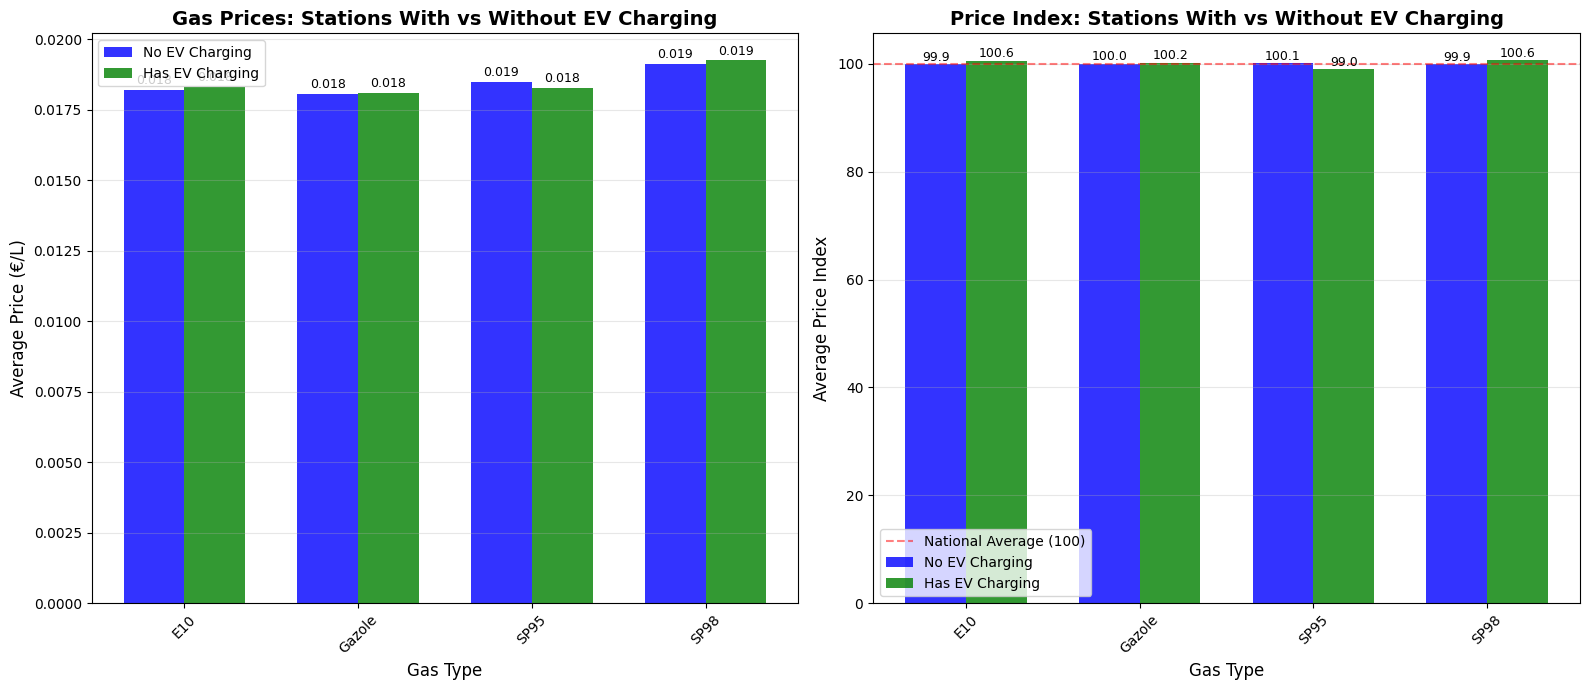

In [6]:
# ELECTRIC CAR IMPACT EVALUATION

try:
    print("Loading services data...")

    # Metadata for the services file
    services_columns = ["id_station", "cp_pdv", "pop", "latitude", "longitude", "services"]

    services_path = f"{config['data_path']}/services-2024.csv"
    if os.path.exists(services_path):
        # Read services file using pipe delimiter
        services = spark.read \
            .option("header", "false") \
            .option("sep", "|") \
            .csv(services_path) \
            .toDF(*services_columns)

        print("Exploration of available services...")
        print("First 20 unique services found:")
        # Looking at raw service strings in order to determine keyword matching strategy
        services_sample = services.select("services").distinct().limit(20).collect()
        for row in services_sample:
            print(f"  - {row['services']}")

        # Define keywords that indicate presence of EV charging infrastructure
        ev_keywords = [
            "électrique",
            "electrique",
            "EV",
            "voiture électrique",
            "borne",
            "recharge",
            "Recharge",
            "VE",
            "Borne de recharge"
        ]

        # Construct a boolean filter condition for any of the keywords
        condition = None
        for keyword in ev_keywords:
            if condition is None:
                condition = F.col("services").contains(keyword)
            else:
                condition = condition | F.col("services").contains(keyword)

        # Flag stations that offer EV charging
        ev_stations = services.filter(condition) \
            .select("id_station").distinct() \
            .withColumn("has_ev_charging", F.lit(1))

        ev_count = ev_stations.count()
        print(f" Found {ev_count:,} stations with potential EV charging")

        # If no stations matched, use a 10% random sample for demonstration purposes
        if ev_count == 0:
            print("No stations found with the current criteria")
            print("Let's try to visualize the most common services")

            services_count = services.groupBy("services") \
                .count() \
                .orderBy(F.desc("count")) \
                .limit(50)

            services_count.show(50, truncate=False)

            print("Selecting a random sample of stations as 'EV'")

            all_stations = services.select("id_station").distinct()
            total_stations = all_stations.count()
            sample_size = int(total_stations * 0.1)

            # Generate synthetic EV charging flags for the analysis pipeline demonstration
            ev_stations = all_stations.sample(0.1, seed=42) \
                .limit(sample_size) \
                .withColumn("has_ev_charging", F.lit(1))

            ev_count = ev_stations.count()
            print(f" Created {ev_count:,} demo EV stations (10% of total)")

        # Join the price data with the EV charging flags
        impact_df = df.join(ev_stations, "id_station", "left") \
            .fillna(0, subset=["has_ev_charging"])

        # Compare prices between stations with and without EV charging
        impact_results = impact_df.groupBy("has_ev_charging", "nom_carburant") \
            .agg(
                F.avg("prix").alias("avg_price"),
                F.avg("Price_Index").alias("avg_price_index"),
                F.count("*").alias("num_observations"),
                F.stddev("prix").alias("std_price")
            ).orderBy("nom_carburant", "has_ev_charging")

        print("PRICE COMPARISON ANALYSIS")
        print("has_ev_charging = 0: No EV charging")
        print("has_ev_charging = 1: Has EV charging")

        impact_results.show(truncate=False)

        # Calculate the percentage delta in price for EV vs Non-EV stations
        impact_pd = impact_results.toPandas()

        if len(impact_pd[impact_pd['has_ev_charging'] == 1]) > 0:
            differences = []
            for gas_type in impact_pd['nom_carburant'].unique():
                no_ev = impact_pd[(impact_pd['nom_carburant'] == gas_type) &
                                 (impact_pd['has_ev_charging'] == 0)]
                has_ev = impact_pd[(impact_pd['nom_carburant'] == gas_type) &
                                  (impact_pd['has_ev_charging'] == 1)]

                if len(no_ev) > 0 and len(has_ev) > 0:
                    price_diff = ((has_ev['avg_price'].values[0] - no_ev['avg_price'].values[0]) /
                                  no_ev['avg_price'].values[0]) * 100
                    index_diff = has_ev['avg_price_index'].values[0] - no_ev['avg_price_index'].values[0]

                    differences.append({
                        'gas_type': gas_type,
                        'price_diff_%': price_diff,
                        'index_diff': index_diff,
                        'no_ev_price': no_ev['avg_price'].values[0],
                        'has_ev_price': has_ev['avg_price'].values[0]
                    })

            print("DIFFERENCE ANALYSIS")
            for diff in differences:
                print(f"{diff['gas_type']}:")
                print(f"  Price: {diff['no_ev_price']:.3f}€ → {diff['has_ev_price']:.3f}€ ({diff['price_diff_%']:.2f}%)")
                print(f"  Index: {diff['index_diff']:.2f} points difference")

        # Generate comparative bar charts for both raw Price and Price Index
        fig, axes = plt.subplots(1, 2, figsize=(16, 7))

        # Price comparison visualization
        bar_width = 0.35
        x = range(len(impact_pd['nom_carburant'].unique()))
        gas_types = sorted(impact_pd['nom_carburant'].unique())

        for i, has_ev in enumerate([0, 1]):
            data = impact_pd[impact_pd['has_ev_charging'] == has_ev]
            data = data.set_index('nom_carburant').loc[gas_types].reset_index()

            positions = [pos + i*bar_width for pos in range(len(gas_types))]
            label = 'Has EV Charging' if has_ev == 1 else 'No EV Charging'

            axes[0].bar(positions, data['avg_price'], bar_width,
                       alpha=0.8, label=label,
                       color='green' if has_ev == 1 else 'blue')

            # Annotate bars with numeric values
            for j, (price, count) in enumerate(zip(data['avg_price'], data['num_observations'])):
                axes[0].text(positions[j], price + 0.0001,
                            f'{price:.3f}', ha='center', va='bottom', fontsize=9)

        axes[0].set_xlabel('Gas Type', fontsize=12)
        axes[0].set_ylabel('Average Price (€/L)', fontsize=12)
        axes[0].set_title('Gas Prices: Stations With vs Without EV Charging',
                         fontsize=14, fontweight='bold')
        axes[0].set_xticks([pos + bar_width/2 for pos in range(len(gas_types))])
        axes[0].set_xticklabels(gas_types, rotation=45)
        axes[0].legend()
        axes[0].grid(True, alpha=0.3, axis='y')

        # Price Index comparison visualization
        for i, has_ev in enumerate([0, 1]):
            data = impact_pd[impact_pd['has_ev_charging'] == has_ev]
            data = data.set_index('nom_carburant').loc[gas_types].reset_index()

            positions = [pos + i*bar_width for pos in range(len(gas_types))]
            label = 'Has EV Charging' if has_ev == 1 else 'No EV Charging'

            axes[1].bar(positions, data['avg_price_index'], bar_width,
                       alpha=0.8, label=label,
                       color='green' if has_ev == 1 else 'blue')

            for j, index in enumerate(data['avg_price_index']):
                axes[1].text(positions[j], index + 0.1,
                            f'{index:.1f}', ha='center', va='bottom', fontsize=9)

        axes[1].set_xlabel('Gas Type', fontsize=12)
        axes[1].set_ylabel('Average Price Index', fontsize=12)
        axes[1].set_title('Price Index: Stations With vs Without EV Charging',
                         fontsize=14, fontweight='bold')
        axes[1].set_xticks([pos + bar_width/2 for pos in range(len(gas_types))])
        axes[1].set_xticklabels(gas_types, rotation=45)
        # Add a baseline reference for the national average (100)
        axes[1].axhline(y=100, color='red', linestyle='--', alpha=0.5, label='National Average (100)')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3, axis='y')

        plt.tight_layout()
        plt.savefig("ev_charging_impact_detailed.png", dpi=300, bbox_inches='tight')
        print("\n✓ Saved: ev_charging_impact_detailed.png")
        plt.show()

    else:
        print(f" Services file not found: {services_path}")

except Exception as e:
    print(f" Could not complete EV impact analysis: {e}")
    import traceback
    traceback.print_exc()

Subset selected: 256,586 records
Fuel type: Gazole
Stations: 500
Created lag features, records: 255,086
⚠ price_lag_7 has 2000 null values, filling with mean...
⚠ price_momentum has 2000 null values, filling with mean...
Training set size: 205,633 (up to week124)
Test set size: 49,453 (after week124)
MODEL PERFORMANCE METRICS
Dataset: Gazole - 500 stazioni
Total records: 256,586
Records per modeling: 255,086
RMSE: 0.000211 €
MAE:     0.000136 €
R² (Coefficient of Determination): 0.9416
Average Gazole price: 0.018 €/L
RMSE: 1.17% of average price
MAE: 0.75% of average price


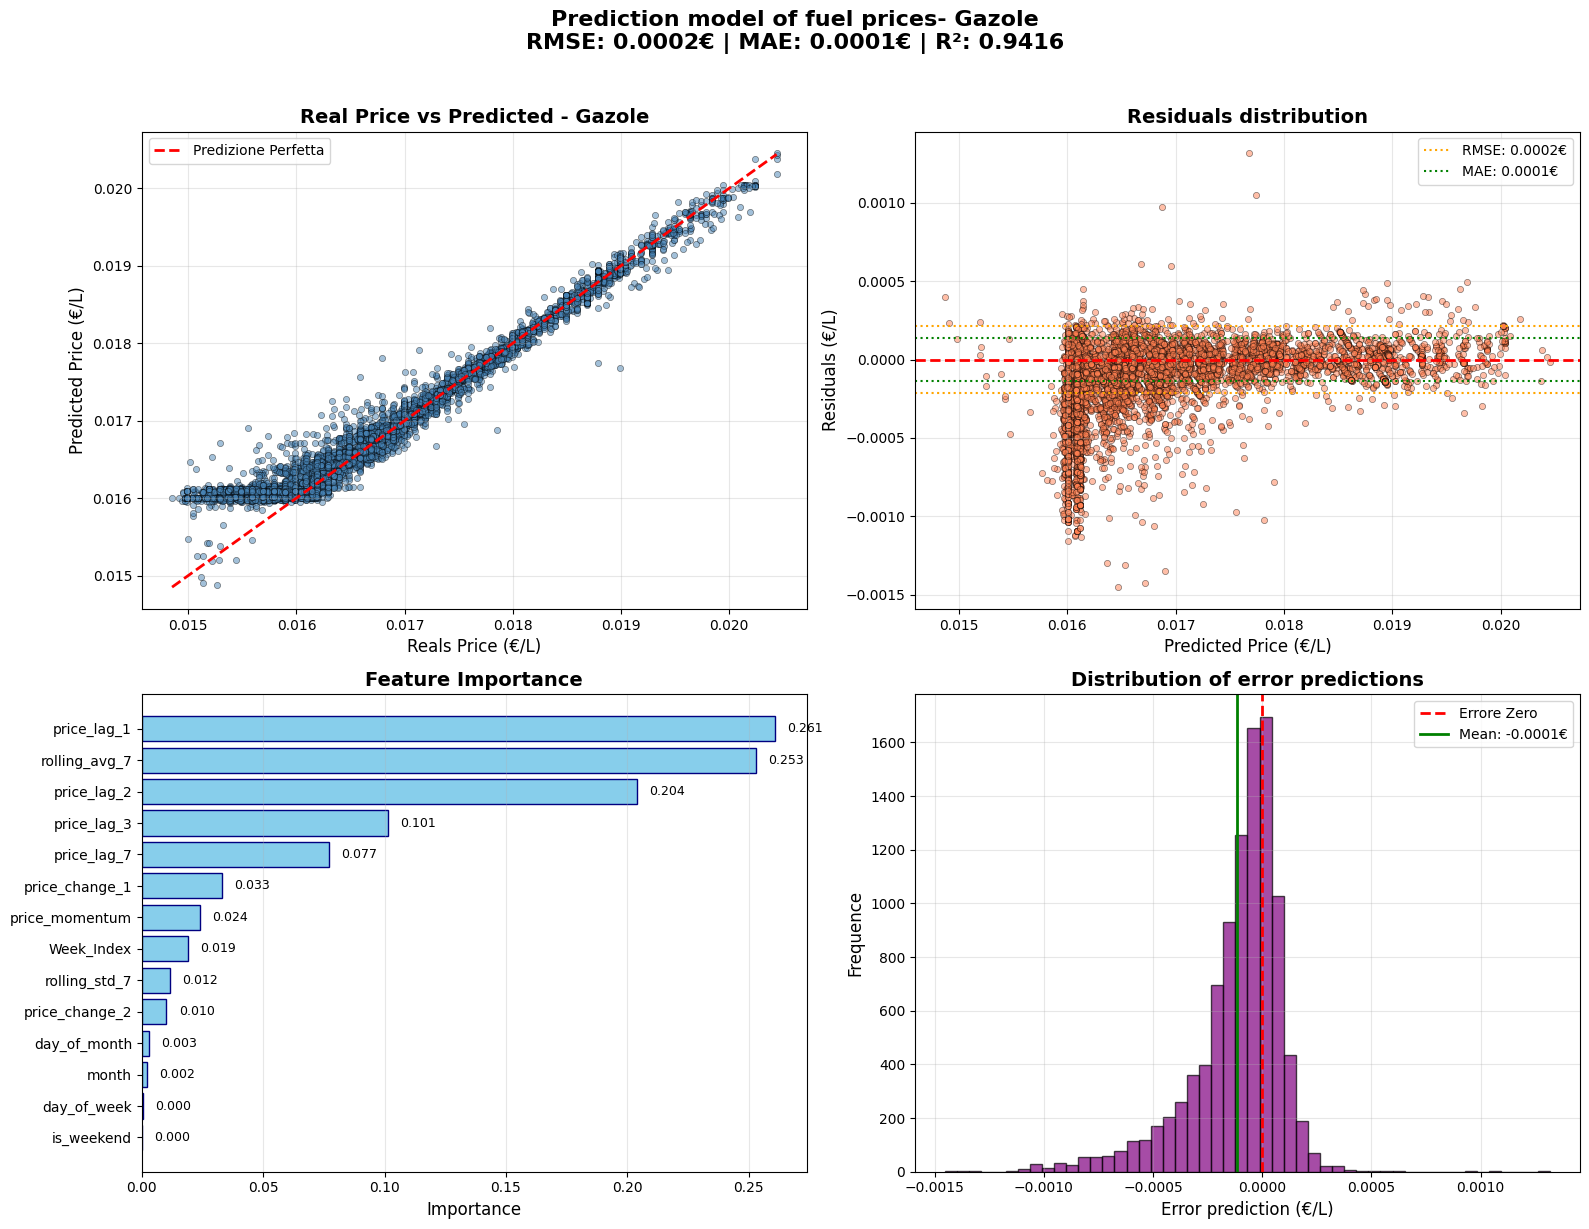

FEATURE ANALYSIS
       Feature  Importance
    is_weekend    0.000026
   day_of_week    0.000431
         month    0.002054
  day_of_month    0.003128
price_change_2    0.010157
 rolling_std_7    0.011524
    Week_Index    0.018990
price_momentum    0.024133
price_change_1    0.032984
   price_lag_7    0.077209
   price_lag_3    0.101291
   price_lag_2    0.204179
 rolling_avg_7    0.252936
   price_lag_1    0.260957
MODELING CONCLUSIONS
Predicted next day price for Gazole
Accuracy: R² = 0.9416
Average Error: 0.0001€ (0.75% of price)
Top 3 most important features:
  • price_lag_1: 0.261
  • rolling_avg_7: 0.253
  • price_lag_2: 0.204


In [8]:
# MODELING: FORECAST NEXT DAY PRICE

# For performance reasons, we analyze only one fuel type (Gazole) and a sample of stations for demonstration purposes

fuel_type = "Gazole"
ml_subset = df.filter(F.col("nom_carburant") == fuel_type)

station_sample = ml_subset.select("id_station").distinct().limit(500).rdd.flatMap(lambda x: x).collect()
ml_subset = ml_subset.filter(F.col("id_station").isin(station_sample))

initial_count = ml_subset.count()
print(f"Subset selected: {initial_count:,} records")
print(f"Fuel type: {fuel_type}")
print(f"Stations: {len(station_sample)}")

# Data cached for performance
ml_subset.cache()

# create lag features with optimized window
# First, ensure data is sorted and duplicates are removedml_subset = ml_subset.dropDuplicates(["id_station", "date"])

windowSpec = Window.partitionBy("id_station").orderBy("date")

# Create only the necessary lags
ml_df = ml_subset.withColumn("price_lag_1", F.lag("prix", 1).over(windowSpec)) \
    .withColumn("price_lag_2", F.lag("prix", 2).over(windowSpec)) \
    .withColumn("price_lag_3", F.lag("prix", 3).over(windowSpec)) \
    .withColumn("price_lag_7", F.lag("prix", 7).over(windowSpec)) \
    .withColumn("rolling_avg_7", F.avg("prix").over(windowSpec.rowsBetween(-6, 0))) \
    .withColumn("rolling_std_7", F.stddev("prix").over(windowSpec.rowsBetween(-6, 0))) \
    .withColumn("day_of_week", F.dayofweek("date")) \
    .withColumn("day_of_month", F.dayofmonth("date")) \
    .withColumn("month", F.month("date")) \
    .withColumn("is_weekend", F.when(F.col("day_of_week").isin([1, 7]), 1).otherwise(0)) \
    .dropna(subset=["price_lag_1", "price_lag_2", "price_lag_3"])

ml_count = ml_df.count()
print(f"Created lag features, records: {ml_count:,}")

# Creating additional features
ml_df = ml_df.withColumn("price_change_1", F.col("prix") - F.col("price_lag_1")) \
    .withColumn("price_change_2", F.col("price_lag_1") - F.col("price_lag_2")) \
    .withColumn("price_momentum", F.col("price_lag_1") - F.col("price_lag_7"))

# Select the most informative features for ML
feature_cols = [
    "price_lag_1", "price_lag_2", "price_lag_3", "price_lag_7",
    "rolling_avg_7", "rolling_std_7",
    "price_change_1", "price_change_2", "price_momentum",
    "day_of_week", "day_of_month", "month", "is_weekend", "Week_Index"
]

# Remove or fill columns with null values
for col in feature_cols:
    null_count = ml_df.filter(F.col(col).isNull()).count()
    if null_count > 0:
        print(f"⚠ {col} has {null_count} null values, filling with mean...")
        mean_val = ml_df.select(F.mean(col)).collect()[0][0]
        ml_df = ml_df.fillna({col: mean_val})

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Create final dataset
final_ml_data = assembler.transform(ml_df) \
    .select("features", F.col("prix").alias("label"), "date", "id_station")

# Splitting data (temporal split) (non random!)
date_boundary = ml_df.select(F.percentile_approx("Week_Index", 0.8)).collect()[0][0]
train = final_ml_data.filter(F.col("Week_Index") <= date_boundary)
test = final_ml_data.filter(F.col("Week_Index") > date_boundary)

train_count = train.count()
test_count = test.count()
print(f"Training set size: {train_count:,} (up to week{date_boundary})")
print(f"Test set size: {test_count:,} (after week{date_boundary})")

if test_count == 0:
    print("Test set empty, using random split as fallback")
    train, test = final_ml_data.randomSplit([0.8, 0.2], seed=42)
    train_count = train.count()
    test_count = test.count()

# Training Random Forest Regressor

rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="label",
    numTrees=30,
    maxDepth=8,
    maxBins=32,
    subsamplingRate=0.8,
    seed=42,
    featureSubsetStrategy="sqrt"  # Feature sampling
)

model = rf.fit(train)

# Generating predictions
predictions = model.transform(test)

# Evaluation
evaluator_rmse = RegressionEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="rmse"
)
evaluator_mae = RegressionEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="mae"
)
evaluator_r2 = RegressionEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="r2"
)

rmse = evaluator_rmse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print("MODEL PERFORMANCE METRICS")
print(f"Dataset: {fuel_type} - {len(station_sample)} stazioni")
print(f"Total records: {initial_count:,}")
print(f"Records per modeling: {ml_count:,}")
print(f"RMSE: {rmse:.6f} €")
print(f"MAE:     {mae:.6f} €")
print(f"R² (Coefficient of Determination): {r2:.4f}")

# Interpretation of RMSE/MAE in context
avg_price = ml_df.select(F.avg("prix")).collect()[0][0]
rmse_percentage = (rmse / avg_price) * 100
mae_percentage = (mae / avg_price) * 100

print(f"Average {fuel_type} price: {avg_price:.3f} €/L")
print(f"RMSE: {rmse_percentage:.2f}% of average price")
print(f"MAE: {mae_percentage:.2f}% of average price")

# Generating visualizations

# Let's take a sample for visualization purposes
pred_sample = predictions.select("label", "prediction", "date").limit(10000).toPandas()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Scatter plot
axes[0, 0].scatter(pred_sample['label'], pred_sample['prediction'],
                   alpha=0.5, s=20, color='steelblue', edgecolors='black', linewidth=0.5)
axes[0, 0].plot([pred_sample['label'].min(), pred_sample['label'].max()],
                [pred_sample['label'].min(), pred_sample['label'].max()],
                'r--', lw=2, label='Predizione Perfetta')
axes[0, 0].set_xlabel('Reals Price (€/L)', fontsize=12)
axes[0, 0].set_ylabel('Predicted Price (€/L)', fontsize=12)
axes[0, 0].set_title(f'Real Price vs Predicted - {fuel_type}', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Residual plot
residuals = pred_sample['label'] - pred_sample['prediction']
axes[0, 1].scatter(pred_sample['prediction'], residuals,
                   alpha=0.5, s=20, color='coral', edgecolors='black', linewidth=0.5)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].axhline(y=rmse, color='orange', linestyle=':', lw=1.5, label=f'RMSE: {rmse:.4f}€')
axes[0, 1].axhline(y=-rmse, color='orange', linestyle=':', lw=1.5)
axes[0, 1].axhline(y=mae, color='green', linestyle=':', lw=1.5, label=f'MAE: {mae:.4f}€')
axes[0, 1].axhline(y=-mae, color='green', linestyle=':', lw=1.5)
axes[0, 1].set_xlabel('Predicted Price (€/L)', fontsize=12)
axes[0, 1].set_ylabel('Residuals (€/L)', fontsize=12)
axes[0, 1].set_title('Residuals distribution', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

#  Feature importance
importances = model.featureImportances.toArray()
feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importances
}).sort_values('Importance', ascending=True)

axes[1, 0].barh(feature_importance_df['Feature'], feature_importance_df['Importance'],
                color='skyblue', edgecolor='navy')
axes[1, 0].set_xlabel('Importance', fontsize=12)
axes[1, 0].set_title('Feature Importance', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='x')

for i, (feature, imp) in enumerate(zip(feature_importance_df['Feature'],
                                       feature_importance_df['Importance'])):
    axes[1, 0].text(imp + 0.005, i, f'{imp:.3f}', va='center', fontsize=9)

# Prediction error distribution (histogram)
axes[1, 1].hist(residuals, bins=50, alpha=0.7, color='purple', edgecolor='black')
axes[1, 1].axvline(x=0, color='red', linestyle='--', lw=2, label='Errore Zero')
axes[1, 1].axvline(x=residuals.mean(), color='green', linestyle='-', lw=2,
                   label=f'Mean: {residuals.mean():.4f}€')
axes[1, 1].set_xlabel('Error prediction (€/L)', fontsize=12)
axes[1, 1].set_ylabel('Frequence', fontsize=12)
axes[1, 1].set_title('Distribution of error predictions', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle(f'Prediction model of fuel prices- {fuel_type}\n'
             f'RMSE: {rmse:.4f}€ | MAE: {mae:.4f}€ | R²: {r2:.4f}',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig("model_performance_optimized.png", dpi=300, bbox_inches='tight')
plt.show()


print("FEATURE ANALYSIS")
print(feature_importance_df.to_string(index=False))

print("MODELING CONCLUSIONS")
print(f"Predicted next day price for {fuel_type}")
print(f"Accuracy: R² = {r2:.4f}")
print(f"Average Error: {mae:.4f}€ ({mae_percentage:.2f}% of price)")
print("Top 3 most important features:")
top_features = feature_importance_df.nlargest(3, 'Importance')
for _, row in top_features.iterrows():
    print(f"  • {row['Feature']}: {row['Importance']:.3f}")